# Collaborative Filtering yöntemini kullanarak benzer seçimleri olan kullanıcılara göre ürün öneri sistemi 

In [103]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_squared_error, pairwise

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline


from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv


# Dataset aktarma

In [104]:
df = pd.read_csv("/kaggle/input/amazon-product-reviews/ratings_Electronics (1).csv",
                             names=['userId', 'productId','rating','timestamp'])

# Verileri inceleme

In [105]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [106]:
print("Toplam Puanlama: ", df.shape[0])
print("Toplam Column: ", df.shape[1])

Toplam Puanlama:  7824482
Toplam Column:  4


In [107]:
print("Toplam rating:",df.rating.nunique())
print("Total kullanıcı  :", df.userId.nunique())
print("Total ürün :", df.productId.nunique())

Toplam rating: 5
Total kullanıcı  : 4201696
Total ürün : 476002


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [109]:
#null değer var mı kontrolü 
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [110]:
#tekrarlayan veri var mı kontrolü 
df[df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [111]:
#rating dağılımları
df.describe()['rating']

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [112]:
#rating skalası
print("Puanlar:",df.rating.unique())

Puanlar: [5. 1. 3. 2. 4.]


# **Verileri Görselleştirme**

In [113]:
# Ürünlerin aldıkları ortalama puanlar
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['puanlanma sayısı'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ortalama'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,puanlanma sayısı,ortalama
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


<AxesSubplot:>

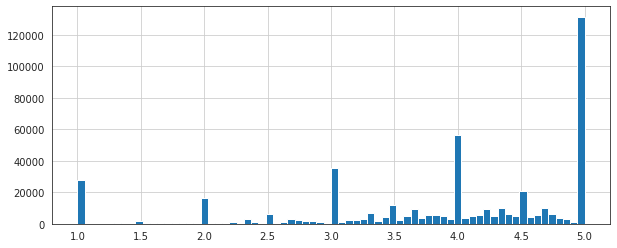

In [114]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

# Veri Setini Filtreleme

Veri setimizin toplam boyutu 7 milyon civarında olduğu için programı çalıştırmada güçlük yaşadık. Bunun sonucunda da yeterli sayıda puanlanmamış ürünleri ve fazla puanlama yapmayan kullanıcıları veri setimizden çıkarttık.

In [115]:
ratings_per_user = df.groupby('userId')['rating'].count()
ratings_per_product = df.groupby('productId')['rating'].count()

In [116]:
#çok fazla rating almayan ürünleri çıkartıyoruz 
ratings_per_product_df =pd.DataFrame(ratings_per_product)
filtered_ratings_per_products_df = ratings_per_product_df[ratings_per_product_df.rating>=850]
popular_product = filtered_ratings_per_products_df.index.tolist()
print(filtered_ratings_per_products_df)


            rating
productId         
0972683275    1051
B00001P4ZH    2075
B00001WRSJ    1586
B00004SABB    1030
B00004SB92    1006
...            ...
B00FFJ0HUE    1278
B00FNPD1VW    1607
B00G2TK76A     998
B00GTGETFG    2667
B00INNP5VU    1097

[858 rows x 1 columns]


In [117]:
#çok fazla yorum yapmamış kullanıcıları çıkartıyoruz 
ratings_per_user_df = pd.DataFrame(ratings_per_user)
filtered_ratings_per_user_df = ratings_per_user_df[ratings_per_user_df.rating>= 70]
pro_users = filtered_ratings_per_user_df.index.tolist()
print(filtered_ratings_per_user_df)

                rating
userId                
A100UD67AHFODS     116
A100WO06OQR8BQ     132
A105TOJ6LTVMBG      71
A10NMELR4KX0J6      96
A10O7THJ2O20AG      80
...                ...
AYNAH993VDECT       81
AYOTEJ617O60K       81
AZ515FFZ7I2P7      144
AZAC8O310IK4E      103
AZMY6E8B52L2T      189

[688 rows x 1 columns]


In [118]:
#filterlıyoruz
filtered_ratings = df[df.productId.isin(popular_product)]
filtered_ratings = df[df.userId.isin(pro_users)]

len(filtered_ratings)

76682

# Kullanıcı - Ürün eşleşmelerini görebilmek için matrix oluşturuyoruz 

In [119]:
#işlerimizi daha kolay yapmak için matrisimizi pivot table'a çevirdik
rating_matrix = pd.pivot_table(filtered_ratings, index='userId', columns = 'productId',values='rating' )
#null değerleri 0'a çevirdik 
rating_matrix = rating_matrix.fillna(0)

n_users = len(rating_matrix.index)
n_products = len(rating_matrix.columns)

print(f"Users: {n_users}\nProducts: {n_products}")

rating_matrix.head()

Users: 688
Products: 33428


productId,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400699169,1685560148,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Elde ettiğimiz sonuçları sonrasında test etmek için train ve test matrisimizi ayıracağız

In [120]:
def train_test_split(data: np.array, n_users: int, n_products:int): 
    # test matrisini oluşturmak için 0 matris yarattık
    test = np.zeros((n_users, n_products))
    train = data.copy()
    
    #her bir kullanıcı için aldıkları 5 ürünü test için ayırıyoruz
    for user in range(n_users):
        random_sample = np.random.choice(data[user, :].nonzero()[0], 
                                         size=5, 
                                         replace=False)
        # trainde az önce çektiğimiz ürünleri almamışlar gibi 0'a eşitliyoruz
        train[user, random_sample] = 0. 
        test[user, random_sample] = data[user, random_sample]
        
    return train, test
train, test = train_test_split(data=rating_matrix.to_numpy(), n_users=n_users, n_products=n_products)

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

train matrisini dataframe'e çeviriyoruz

In [121]:
train_df.index = rating_matrix.index
train_df.columns = rating_matrix.columns
train_df

productId,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400699169,1685560148,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYNAH993VDECT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOTEJ617O60K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ515FFZ7I2P7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


test matrisini dataframe'e çeviriyoruz

In [122]:
test_df.index = rating_matrix.index
test_df.columns = rating_matrix.columns
test_df

productId,0594481813,0970407998,0972683275,1400501466,1400501776,1400532620,1400532655,1400599997,1400699169,1685560148,...,B00L3YHF6O,B00L403O94,B00L43HAY6,B00L5YZCCG,B00L8I6SFY,B00LA6T0LS,B00LBZ1Z7K,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10NMELR4KX0J6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10O7THJ2O20AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYNAH993VDECT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOTEJ617O60K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ515FFZ7I2P7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Benzer kullanıcıları cosine similarity kullanarak bulacağız 

In [123]:
from sklearn.metrics.pairwise import cosine_similarity
import operator

def similar_users(userId, matrix,k=3):
    #trainde bizim öneri sunmak istediğimiz kullanıcıyı buluyoruz. 
    #o kullanıcıyı diğer kullanıcılardan ayırıyoruz
    user = matrix[matrix.index == userId]
    other_users = matrix[matrix.index != userId]
    
    #fonksiyon yardımıyla kullanıcılar arasındaki kosinüs benzerliğini buluyoruz
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    indices = other_users.index.tolist()
    
    #kullanıcılar ve onların bizim seçtiğimiz kullanıcılarla olan benzerlik sayılarını bir sözlüğe atıyoruz 
    index_similarity = dict(zip(indices, similarities))
    
    #bu sözlüğü benzerliğe göre en yüksekten en aza doğru sıralıyoruz 
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    #en çok benzeyen k kullanıcıyı seçiyoruz
    top_users_similarities = index_similarity_sorted[:k]
    
    users = [u[0] for u in top_users_similarities]
    
    return users

current_user = input("Kullanici giriniz: ")

similar_user_indices = similar_users(current_user,train_df)
print(similar_user_indices)

Kullanici giriniz:  AZMY6E8B52L2T


['A3V5F050GVZ56Q', 'A328S9RN3U5M68', 'AX05DBU8IRUWY']


# Ürün önerme

In [124]:
def recommend_item(user_index, similar_user_indices, matrix, items=5):
    
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    
    # benzer kişilerin ortalama puanları
    similar_users = similar_users.mean(axis=0)
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    user_df = matrix[matrix.index == user_index]
    user_df_transposed = user_df.transpose()

    user_df_transposed.columns = ['rating']
    # henüz satın alınmamış ürünleri bırakıyoruz 
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # satın alınmamış ürünleri bir listeye alıyoruz
    not_purchased_prod = user_df_transposed.index.tolist()
    
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # istenilen sayı kadar öneri sunuyoruz  
    top_n_product = similar_users_df_ordered.head(items)
    top_n_product_indices = top_n_product.index.tolist()
    
    product_information = df[df['productId'].isin(top_n_product_indices)]
    
    print(product_information.groupby('productId').mean())
    
    test_filtered_df = test_df[test_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)

    return top_n_product_indices 

results = recommend_item(current_user, similar_user_indices, train_df)
print()
print(results)


              rating     timestamp
productId                         
B0082E9K7U  4.628722  1.390016e+09
B00AYQ433U  4.328165  1.389664e+09
B00EFE9OAE  4.243902  1.392701e+09
B00G56ZNZU  4.445455  1.395765e+09
B00HG1L334  4.857143  1.399868e+09

['B00G56ZNZU', 'B00EFE9OAE', 'B00AYQ433U', 'B0082E9K7U', 'B00HG1L334']


In [125]:
df[df['userId'] == current_user]

,userId,productId,rating,timestamp
9859,AZMY6E8B52L2T,B00000J1EQ,5.0,1350691200
32644,AZMY6E8B52L2T,B00003006K,5.0,1336262400
120670,AZMY6E8B52L2T,B00005T3G0,5.0,1330819200
146347,AZMY6E8B52L2T,B000066E6Y,5.0,1327968000
172308,AZMY6E8B52L2T,B00006B82A,5.0,1371772800
...,...,...,...,...
7823632,AZMY6E8B52L2T,B00KVNY2KA,5.0,1404950400
7823805,AZMY6E8B52L2T,B00KXAFYZS,5.0,1404950400
7824067,AZMY6E8B52L2T,B00L21HC7A,5.0,1404864000
7824082,AZMY6E8B52L2T,B00L2442H0,5.0,1396742400


# Test Matrisimizdeki ürünlere bakıyoruz 

In [126]:
m1 = (test_df.index == current_user)
m2 = (test_df[m1] != 0).all()
a = test_df.loc[m1,m2]
print(a)


productId      B001MSU1FS  B0036FFNN0  B003M5IQLU  B008BGXZV6  B00EQD5ZS4
userId                                                                   
AZMY6E8B52L2T         4.0         5.0         1.0         5.0         5.0


Test matrisimizdeki ürünlere benzer kullanıcıları kullanarak tahmini bir puan veriyoruz.
Aşağıdaki fonksiyon yukarıda tanımladığımız ve sonrasında traindeki verilere tahmini puanlama yapmak için kullandığımız fonksiyonla aynı mantıkta çalışmakta. İkisi arasındaki tek fark burda veri olarak test verisini kullanmamız ve test verisindeki ürünlere puanlama yaptırmaya çalıştığımız için daha önce puan almış ürünleri seçtirmemiz. 

In [127]:
def recommend_item2(user_index, similar_user_indices, matrix, items=5):
    
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    

    similar_users = similar_users.mean(axis=0)
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    user_df = matrix[matrix.index == user_index]
    user_df_transposed = user_df.transpose()

    user_df_transposed.columns = ['rating']
    #diğer fonksiyondan farklı kısım
    #seçtiğimiz kullanıcının daha önceden puanladığı ürünü seçiyoruz. 
    user_df_transposed = user_df_transposed[user_df_transposed['rating']!=0]

    not_purchased_prod = user_df_transposed.index.tolist()
    
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)

    top_n_product = similar_users_df_ordered.head(items)
    top_n_product_indices = top_n_product.index.tolist()
    
    product_information = df[df['productId'].isin(top_n_product_indices)]
    
    print(product_information.groupby('productId').mean())
    
    test_filtered_df = test_df[test_df.index.isin(not_purchased_prod)]
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)

    return top_n_product_indices 

In [128]:
# seçtiğimiz kullanıcının puanladığı ürünleri test matrisinde seçiyoruz 
m1 = (test_df.index == current_user)
m2 = (test_df[m1] != 0).all()
a = test_df.loc[m1,m2]

In [129]:
#recommend_item2 fonksiyonundan gelen puanlamalar
results2 = recommend_item2(current_user, similar_user_indices, a)

              rating     timestamp
productId                         
B001MSU1FS  4.762032  1.357853e+09
B0036FFNN0  3.642857  1.361247e+09
B003M5IQLU  2.833729  1.325488e+09
B008BGXZV6  4.620690  1.373465e+09
B00EQD5ZS4  4.557692  1.395977e+09
